In [1]:
# работа с данными
import pandas as pd
import numpy as np

# статистика
from scipy import stats

# визуализации
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import objects as so
from plotly import express as pe
import ipywidgets as ipw
import aquarel as aq

# системные библиотеки
from pathlib import Path
import logging


# ml

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, TunedThresholdClassifierCV


from itertools import combinations
from datetime import datetime
import logging
import ipynbname

In [2]:
# Configure the logging settings
logging.basicConfig(
    format='%(asctime)s %(levelname)s %(message)s',  # Set the log message format
    datefmt='%Y-%m-%d %H:%M:%S',  # Set the date format
    level=logging.INFO  # Set the logging level to INFO
)

# Create a logger object
logger = logging.getLogger(__name__)

logger.info("Logger has been configured successfully.")

2024-12-01 17:11:04 INFO Logger has been configured successfully.


In [3]:
# Загружаем тему, чтобы диаграммы были красивее

print(aq.list_themes())

aq.load_theme('arctic_light')

['umbra_light', 'minimal_dark', 'boxy_light', 'arctic_dark', 'arctic_light', 'minimal_light', 'umbra_dark', 'gruvbox_dark', 'gruvbox_light', 'scientific', 'boxy_dark']


# Константы

In [4]:
ROOT = Path(".").absolute().parent.parent

DATA = ROOT / "data"
DATA_RAW = DATA / "raw"
DATA_PROCESSED = DATA / "processed"
DATA_CLEAN = DATA / "clean"

# Вспомогательный код

In [5]:
from typing import Optional

def get_timestamp() -> str:
    """
    Generates a timestamp string in the format YYYY-MM-DD-HH-MM-SS.
    
    Returns:
        str: The formatted timestamp.
    """
    dt = datetime.now()
    return dt.strftime("%Y-%m-%d-%H-%M-%S")

def get_filename(
        fname: Optional[str] = None,
        extension: str = 'parquet',
    ) -> str:
    """
    Generates a filename based on the provided name and current timestamp.
    
    Args:
        fname (Optional[str]): The base filename. If None, the current notebook name is used.
        extension (str): The file extension to use. Default is 'parquet'.
    
    Returns:
        str: The generated filename with timestamp and extension.
    """
    base_filename: str = fname if fname else ipynbname.name()
    return f"{base_filename}_{get_timestamp()}.{extension}"

In [6]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef
from sklearn.model_selection import LeavePOut, cross_val_predict
from sklearn.base import clone

def get_scores(estimator,x, y):
    # Assuming 'x' is your feature set, and 'y' is your target variable
    unique_classes = np.unique(y)
    scores = []
    f1_scores = []
    mcc_scores = []

    # Loop through each class
    for cls in unique_classes:
        # Create a binary target variable
        binary_y = np.where(y == cls, 1, 0)

        # Use cross_val_predict to get predicted probabilities
        y_pred_proba = cross_val_predict(estimator, x, binary_y, cv=3, method='predict_proba')[:, 1]

        # Use TunedThresholdClassifierCV to find the optimal threshold
        # Assuming TunedThresholdClassifierCV is defined and imported
        try:
            tuned_threshold_model = TunedThresholdClassifierCV(clone(estimator))
            tuned_threshold_model.fit(x, binary_y)

            # Get the optimal threshold
            optimal_threshold = tuned_threshold_model.best_threshold_

            # Make predictions based on the optimal threshold
            y_pred = (y_pred_proba >= optimal_threshold).astype(int)

            # Calculate the ROC AUC score
            score = roc_auc_score(binary_y, y_pred_proba)
            scores.append(score)

            # Calculate F1 score
            f1 = f1_score(binary_y, y_pred)
            f1_scores.append(f1)

            # Calculate Matthews correlation coefficient
            mcc = matthews_corrcoef(binary_y, y_pred)
            mcc_scores.append(mcc)
        except:
            scores.append(np.nan)
            f1_scores.append(np.nan)
            mcc_scores.append(np.nan)
            

    # Calculate the average scores weighted by each class share in the target
    class_weights = [np.sum(y == cls) / len(y) for cls in unique_classes]
    weighted_average_score = np.average(scores, weights=class_weights)
    weighted_average_f1 = np.average(f1_scores, weights=class_weights)
    weighted_average_mcc = np.average(mcc_scores, weights=class_weights)
    
    max_score = np.max(scores)
    max_f1 = np.max(f1_scores)
    max_mcc = np.max(mcc_scores)

    return (
        weighted_average_score, 
        weighted_average_f1, 
        weighted_average_mcc,
        max_score,
        max_f1,
        max_mcc,
    )

In [7]:
def add_coefficients(df: pd.DataFrame) -> pd.DataFrame:
    selected_pairs = set([
        ('fixed_acidity', 'alcohol'),
        ('volatile_acidity', 'alcohol'),
        ('chlorides', 'pH'),
        ('chlorides', 'alcohol'),
        ('total_sulfur_dioxide', 'sulphates'),
        ('density', 'alcohol'),
        ('pH', 'alcohol'),
        ('residual_sugar', 'chlorides'),
        ('residual_sugar', 'density'),
        ('residual_sugar', 'sulphates'),
        ('total_sulfur_dioxide', 'density'),
        ('pH', 'sulphates'),
        ('fixed_acidity', 'free_sulfur_dioxide'),
        ('fixed_acidity', 'alcohol'),
        ('volatile_acidity', 'free_sulfur_dioxide'),
        ('density', 'alcohol'),
        ('pH', 'alcohol'),
    ])
    
    _df = df.copy()
    
    for f1, f2 in selected_pairs:
        _df[f"{f1}_DIV_{f2}"] = _df[f1] / _df[f2]
        
    return _df

# Гипотеза

Попробуем сгенерировать новые фичи для анализа.

**Внимание! Все, что происходит ниже, происходит в демонстрационных целях, для иллюстрации того, как удобно ОФРОМЛЯТЬ проект. НЕ НАДО ВОСПРИНИМАТЬ ЭТО КАК ПОПЫТКУ РЕШИТЬ ЗАДАЧУ ОБ ОПРЕДЕЛЕНИИ КАЧЕСТВА ВИНА!**

# Результаты

- написана функция для обогащения датасета коэффициентами вида фича 1 / фича 2: add_coefficients
- оценена предсказательная сила разных коэффициентов, таблица с оценками сохранена в **data/clean** под именем coefficient_metrics_{ts}.ipynb
- набор данных разбит на обучающую и валидационную выборки, добавлен столбец is_train, принимающий значение 1 для обучающей выборки и 0 - для валидационной
- добавлены наиболее перспективные для классификации коэффициенты

# Анализ

In [8]:
df = pd.read_parquet(DATA_RAW / 'wine_data_2024-11-04-19-36-13.parquet')

In [9]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,rc
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,1
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,1
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,1
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,1
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,1


Разделим набор на обучающую и тестовую выборки. Дальше будем использовать толкьо обучающую выборку для поиска сязей фич и таргета.

In [10]:
train = df.sample(frac=0.7,random_state=123).copy()
test = df[~df.index.isin(train.index)].copy()

In [11]:
pd.concat(
    [
        train.mean(),
        test.mean(),
    ],
    axis=1
).rename(columns={0:'train',1:'test'})

,train,test
fixed_acidity,7.206366,7.236897
volatile_acidity,0.342750,0.347486
citric_acid,0.318541,0.318476
residual_sugar,5.034676,5.084451
chlorides,0.056369,0.057473
free_sulfur_dioxide,29.871878,30.400627
total_sulfur_dioxide,113.946817,114.483386
density,0.994518,0.994579
pH,3.224789,3.224288
sulphates,0.533242,0.533774


In [12]:
train.quality.value_counts().sort_index()

quality
3      19
4     151
5    1219
6    1629
7     597
8     104
9       4
Name: count, dtype: int64

In [13]:
test.quality.value_counts().sort_index()

quality
3     11
4     55
5    532
6    694
7    258
8     44
9      1
Name: count, dtype: int64

In [14]:
base_features = train.columns[:-2].tolist()

base_features

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [15]:
for c in combinations(base_features, 2):
    print(c)

('fixed_acidity', 'volatile_acidity')
('fixed_acidity', 'citric_acid')
('fixed_acidity', 'residual_sugar')
('fixed_acidity', 'chlorides')
('fixed_acidity', 'free_sulfur_dioxide')
('fixed_acidity', 'total_sulfur_dioxide')
('fixed_acidity', 'density')
('fixed_acidity', 'pH')
('fixed_acidity', 'sulphates')
('fixed_acidity', 'alcohol')
('volatile_acidity', 'citric_acid')
('volatile_acidity', 'residual_sugar')
('volatile_acidity', 'chlorides')
('volatile_acidity', 'free_sulfur_dioxide')
('volatile_acidity', 'total_sulfur_dioxide')
('volatile_acidity', 'density')
('volatile_acidity', 'pH')
('volatile_acidity', 'sulphates')
('volatile_acidity', 'alcohol')
('citric_acid', 'residual_sugar')
('citric_acid', 'chlorides')
('citric_acid', 'free_sulfur_dioxide')
('citric_acid', 'total_sulfur_dioxide')
('citric_acid', 'density')
('citric_acid', 'pH')
('citric_acid', 'sulphates')
('citric_acid', 'alcohol')
('residual_sugar', 'chlorides')
('residual_sugar', 'free_sulfur_dioxide')
('residual_sugar', 'to

In [16]:
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)
from tqdm import tqdm

feature_combs  = list(combinations(base_features, 2))


coef_metrics = []

for f1, f2 in tqdm(feature_combs): 

    feature_1 = train[f1]
    feature_2 = train[f2]

    coef = feature_1 / (feature_2 + 1)

    x = coef.values.reshape((-1,1))
    y = train.quality.values

    t = DecisionTreeClassifier(random_state=123, max_depth=3)
    scores = get_scores(t, x, y)
    coef_metrics.append({
        'feature_1': f1,
        'feature_2': f2,
        'wa_roc_auc': scores[0],
        'wa_f1': scores[1],
        'wa_mcc': scores[2],
        'max_roc_auc': scores[3],
        'max_f1': scores[4],
        'max_mcc': scores[5],
    })

100%|███████████████████████████████████████████| 55/55 [02:12<00:00,  2.40s/it]


In [17]:
coef_metrics = pd.DataFrame(coef_metrics)

<Axes: ylabel='Frequency'>

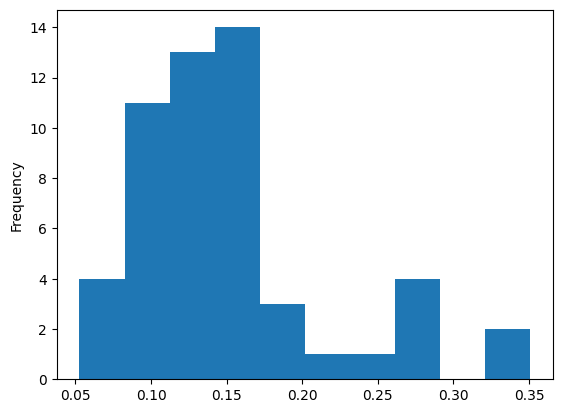

In [18]:
coef_metrics.max_mcc.plot.hist()

<Axes: ylabel='Frequency'>

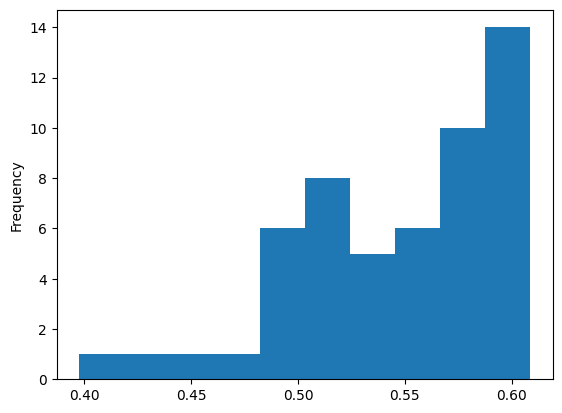

In [19]:
coef_metrics.max_f1.plot.hist()

<Axes: ylabel='Frequency'>

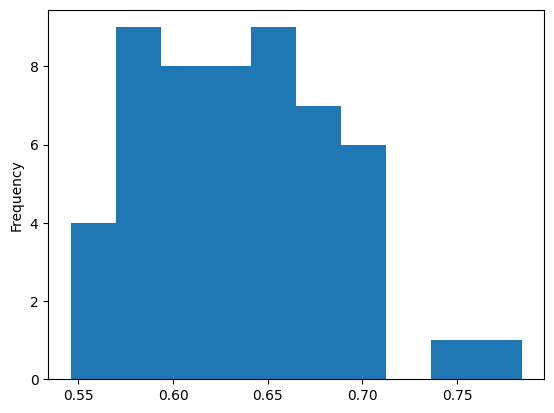

In [20]:
coef_metrics.max_roc_auc.plot.hist()

In [21]:
coef_metrics.query("max_mcc>=0.24")

,feature_1,feature_2,wa_roc_auc,wa_f1,wa_mcc,max_roc_auc,max_f1,max_mcc
9,fixed_acidity,alcohol,0.608929,0.451125,0.151535,0.702160,0.552730,0.269262
18,volatile_acidity,alcohol,0.620955,0.458127,0.186513,0.663914,0.537088,0.261701
37,chlorides,pH,0.592352,0.465163,0.146626,0.653554,0.546553,0.242468
39,chlorides,alcohol,0.614555,0.480406,0.165913,0.695091,0.553021,0.268872
47,total_sulfur_dioxide,sulphates,0.548935,0.221183,0.070108,0.626535,0.490377,0.279045
51,density,alcohol,0.657766,0.522521,0.228238,0.784051,0.592716,0.350853
53,pH,alcohol,0.634600,0.487941,0.192149,0.756482,0.585797,0.329144


In [22]:
coef_metrics.query("max_f1>=0.6")

,feature_1,feature_2,wa_roc_auc,wa_f1,wa_mcc,max_roc_auc,max_f1,max_mcc
27,residual_sugar,chlorides,0.523248,0.417315,0.039291,0.578016,0.602687,0.109945
30,residual_sugar,density,0.524400,0.423374,0.047089,0.575580,0.607991,0.113175
32,residual_sugar,sulphates,0.523467,0.452025,0.036754,0.597852,0.608744,0.117633
45,total_sulfur_dioxide,density,0.552407,0.467963,0.063683,0.637334,0.604766,0.113322
52,pH,sulphates,0.532826,0.463646,0.053063,0.575402,0.607284,0.111820


In [23]:
coef_metrics.query("max_roc_auc>=0.7")

,feature_1,feature_2,wa_roc_auc,wa_f1,wa_mcc,max_roc_auc,max_f1,max_mcc
4,fixed_acidity,free_sulfur_dioxide,0.547906,0.457795,0.080761,0.700217,0.581227,0.144461
9,fixed_acidity,alcohol,0.608929,0.451125,0.151535,0.702160,0.552730,0.269262
13,volatile_acidity,free_sulfur_dioxide,0.550050,0.428839,0.086269,0.704060,0.568627,0.167801
51,density,alcohol,0.657766,0.522521,0.228238,0.784051,0.592716,0.350853
53,pH,alcohol,0.634600,0.487941,0.192149,0.756482,0.585797,0.329144


Сохраним данные о метриках в отдельный файл, которым можно делиться, в data/clean

In [24]:
fname = get_filename('coefficients_mentrcs', extension='xlsx')

coef_metrics.to_excel(DATA_CLEAN / fname)
logger.info("%s saved to data/clean", fname)

2024-12-01 17:13:20 INFO coefficients_mentrcs_2024-12-01-17-13-20.xlsx saved to data/clean


Выберем наиболее подходящие фичи.

In [33]:
coef_metrics.query("max_roc_auc>=0.7")[['feature_1','feature_2']].apply(tuple, axis=1).tolist()

[('fixed_acidity', 'free_sulfur_dioxide'),
 ('fixed_acidity', 'alcohol'),
 ('volatile_acidity', 'free_sulfur_dioxide'),
 ('density', 'alcohol'),
 ('pH', 'alcohol')]

Добавим их к датасету и сохраним его.

In [34]:
df_to_save = pd.concat(
    [
        add_coefficients(train.assign(is_train=1)),
        add_coefficients(test.assign(is_train=0)),
    ]
)

In [35]:
fname = get_filename()

df_to_save.to_parquet(DATA_PROCESSED / fname)
logger.info("%s saved to data/processed", fname)

2024-12-01 17:13:30 INFO enrich_features_2024-12-01-17-13-30.parquet saved to data/processed
